# 1. Preprocess seismic waveforms

An essential step before detecting and locating earthquakes is the adequate preprocessing of the seismic data. Preprocessing addresses specific needs for a given data set and task and, thus, cannot be straightforwardly generalized to new data sets. Preprocessing workflows must remain as simple as possible. The preprocessing steps taken in this notebook are given as an example and should not be blindly reproduced on other data sets.

### Contents

* [Read and destination paths](#read-and-destination-paths)

* [Show an example raw trace](#show-an-example-raw-trace)
* [Process](#process)
* [Compare raw and processed trace](#compare-raw-and-processed-traces)

In [1]:
import obspy
import os
import tqdm

import matplotlib.pyplot as plt

from glob import glob

## Read and destination paths

First, we define the path from which we read the raw data and save the preprocessed data. Also extract the path to all input waveforms.

In [2]:
DIRPATH_RAW = "../data/raw/"
DIRPATH_PROCESSED = "../data/processed/"

Again create directory if needed and copy the metadata therein.

In [3]:
# Create directory
os.makedirs(DIRPATH_PROCESSED, exist_ok=True)

# Copy meta to destination
!cp {DIRPATH_RAW}*xml {DIRPATH_PROCESSED}

## Show an example raw trace

We collect all available waveform files to manipulate them afterward.

In [4]:
filepaths_raw = sorted(glob(os.path.join(DIRPATH_RAW, "*.mseed")))

Using `obspy`, we can visualize the waveforms. In the following cell, the selected waveform has not been preprocessed yet: the amplitudes are in counts (signed integers) and the waveform exhibits low-frequency components, especially with a day-long period. Note that, here, we do not show the earthquake itself to see the ambient noise better.

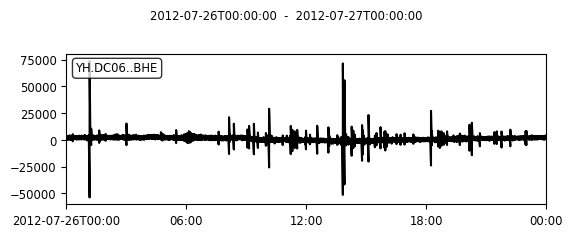

<Figure size 640x480 with 0 Axes>

In [5]:
stream = obspy.read(filepaths_raw[0])
stream.plot(size=(600, 250), show=True)
plt.gcf().set_facecolor('w')

## Preprocess

The next cell loads every waveform and applies the preprocessing workflow, which includes detrending individual segments, filling gaps over the entire day, synchronizing the traces on the requested start and end times, resampling at the target sampling rate and removing the instrument gain. This cell runs in about 3 minutes on a desktop machine.

In [6]:
TARGET_SAMPLING_RATE = 25.0
MAX_SEGMENTS = 10
FREQ_MIN = 2.0
FREQ_MAX = 12.0
TAPER_PERCENT = 0.02
TAPER_TYPE = "cosine"
MSEED_ENCODING = "FLOAT64"
TARGET_STARTTIME = obspy.UTCDateTime("2012-07-26")
TARGET_ENDTIME = obspy.UTCDateTime("2012-07-27")

for filepath_waveform in tqdm.tqdm(filepaths_raw, desc="Processing data"):

    # Read trace
    trace = obspy.read(filepath_waveform)[0]

    # Split trace into segments to process them individually
    stream = trace.split()

    # Apply detrend on segments
    stream.detrend("constant")
    stream.detrend("linear")
    stream.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Merge traces, filling gaps with zeros and imposing start and end times
    stream = stream.merge(fill_value=0.0)
    trace = stream[0]
    trace.trim(starttime=TARGET_STARTTIME, endtime=TARGET_ENDTIME, pad=True, fill_value=0.0)

    # Resample at target sampling rate
    trace.resample(TARGET_SAMPLING_RATE)

    # Attach instrument response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_RAW, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    trace.attach_response(inventory)

    # Remove instrument gain
    trace.remove_sensitivity()

    # Detrend
    trace.detrend("constant")
    trace.detrend("linear")
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Filter
    trace.filter(
        "bandpass", freqmin=FREQ_MIN, freqmax=FREQ_MAX, zerophase=True
    )
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Write processed traces
    _, filename = os.path.split(filepath_waveform)
    filepath_processed_waveform = os.path.join(DIRPATH_PROCESSED, filename)
    trace.write(filepath_processed_waveform, encoding=MSEED_ENCODING)


Processing data:   0%|          | 0/24 [00:00<?, ?it/s]

Processing data: 100%|██████████| 24/24 [01:34<00:00,  3.95s/it]


## Compare raw and processed traces

After the preprocessing, we see that the low-frequency components were filtered out as a result of the bandpass filter, and we see that the waveform amplitude is units of velocity (m/s). Impulsive signals are also more visible.

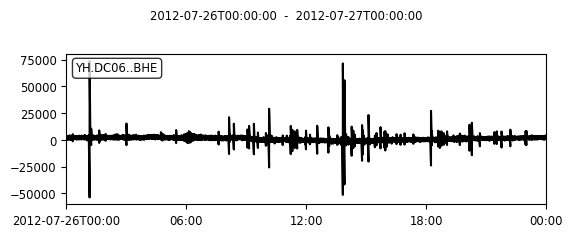

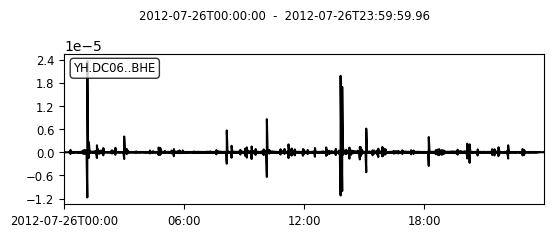

In [7]:
# Get a file to read
filepath_raw = filepaths_raw[0]
filename_raw = os.path.basename(filepath_raw)
filepath_processed = os.path.join(DIRPATH_PROCESSED, filename_raw)

# Loop over cases and show
for filepath in (filepath_raw, filepath_processed):
    stream = obspy.read(filepath)
    stream.plot(size=(600, 250), show=True)